# Predicting the Length of Stay in ICU from MIMIC 2 Datasets

## Load datasets from GitHub repository
https://github.com/wyliadrian/BIS-550-Final-Project

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Codes in this chunk are originally for loading datasets into Google Colab from Kaggle
# datasets were saved on GitHub for easier access
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Colab Notebooks/BIS 550/Final Project"
# ! pip install kaggle
# ! chmod 600 kaggle.json
# ! kaggle datasets download drscarlat/mimic2-original-icu
# ! unzip mimic2-original-icu.zip
# import shutil
# shutil.rmtree('/folder_name')

In [3]:
# Clone the Final Project GitHub repository
# This will create a new directory in /content copying everything from GitHub
!git clone https://github.com/wyliadrian/BIS-550-Final-Project.git

Cloning into 'BIS-550-Final-Project'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 80 (delta 18), reused 37 (delta 1), pack-reused 0
Unpacking objects: 100% (80/80), 31.87 MiB | 2.83 MiB/s, done.


In [4]:
# Change working directory to the new folder
%cd /content/BIS-550-Final-Project/

/content/BIS-550-Final-Project


In [5]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from datetime import datetime
from sqlite3 import Error
from IPython.display import display
from functools import reduce
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import r2_score, classification_report 
from sklearn import tree, ensemble
import plotly.express as px  
import plotly.graph_objects as go 
import graphviz 
from tqdm import tqdm

%matplotlib inline

## Relational Database Creation

In [6]:
# create a database connection to the relational database 
conn = None
conn = sqlite3.connect('./mimic2.db')
cursor = conn.cursor()

In [7]:
# Doping tables if already exists.
cursor.execute("DROP TABLE IF EXISTS d_patients")
cursor.execute("DROP TABLE IF EXISTS admissions")
cursor.execute("DROP TABLE IF EXISTS icustayevents")
cursor.execute("DROP TABLE IF EXISTS demographic_detail")
cursor.execute("DROP TABLE IF EXISTS d_codeditems")
cursor.execute("DROP TABLE IF EXISTS drgevents")
cursor.execute("DROP TABLE IF EXISTS icustay_detail")
cursor.execute("DROP TABLE IF EXISTS labevents")

In [8]:
# Creating tables from csv files including our desired variables
sql ='''CREATE TABLE d_patients (
    subject_id int NOT NULL,
    sex varchar(5),
    dob datetime,
    dod datetime,
    hospital_expire_flg varchar(5),
    PRIMARY KEY (subject_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

d_patients = pd.read_csv('./MIMIC2csv/d_patients.csv')
d_patients.to_sql('d_patients', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


In [9]:
# Creating tables
sql ='''CREATE TABLE admissions (
    hadm_id int NOT NULL,
    subject_id int NOT NULL,
    admit_dt datetime,
    disch_dt datetime,
    PRIMARY KEY (hadm_id),
    FOREIGN KEY (subject_id) REFERENCES d_patients(subject_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

admissions = pd.read_csv('./MIMIC2csv/admissions.csv')
admissions.to_sql('admissions', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


In [10]:
# Creating tables
sql ='''CREATE TABLE icustayevents (
    icustay_id int NOT NULL,
    subject_id int NOT NULL,
    intime datetime,
    outtime datetime,
    los int,
    first_careunit int,
    last_careunit int,
    PRIMARY KEY (icustay_id),
    FOREIGN KEY (subject_id) REFERENCES d_patients(subject_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

icustayevents = pd.read_csv('./MIMIC2csv/icustayevents.csv')
icustayevents.to_sql('icustayevents', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


In [11]:
# Creating tables
sql ='''CREATE TABLE demographic_detail (
    subject_id int NOT NULL,    
    hadm_id int NOT NULL,
    marital_status_itemid int,
    marital_status_descr varchar(20),    
    ethnicity_itemid int,
    ethnicity_descr varchar(30),
    overall_payor_group_itemid int, 
    overall_payor_group_descr varchar(20),
    religion_itemid int,
    religion_descr varchar(30),
    admission_type_itemid int,
    admission_type_descr varchar(10),
    admission_source_itemid int,
    admission_source_descr varchar(30),
    FOREIGN KEY (subject_id) REFERENCES d_patients(subject_id),
    FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

demographic_detail = pd.read_csv('./MIMIC2csv/demographic_detail.csv')
demographic_detail.to_sql('demographic_detail', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


In [12]:
# Creating tables
sql ='''CREATE TABLE d_codeditems (
    itemid int NOT NULL,
    code varchar(10),
    type varchar(12),
    category varchar(13),
    label varchar(100),
    description varchar(100),
    PRIMARY KEY (itemid)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

d_codeditems = pd.read_csv('./MIMIC2csv/d_codeditems.csv')
d_codeditems.to_sql('d_codeditems', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


In [13]:
# Creating tables
sql ='''CREATE TABLE drgevents (
    subject_id int NOT NULL,    
    hadm_id int NOT NULL,
    itemid int NOT NULL,
    cost_weight int,
    FOREIGN KEY (subject_id) REFERENCES d_patients(subject_id),
    FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id),
    FOREIGN KEY (itemid) REFERENCES d_codeditems(itemid)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

drgevents = pd.read_csv('./MIMIC2csv/drgevents.csv')
drgevents.to_sql('drgevents', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


In [14]:
# Creating tables
sql ='''CREATE TABLE icustay_detail (
    icustay_id int NOT NULL,
    subject_id int NOT NULL,
    gender varchar(5),
    dob datetime,
    dod datetime
    expire_flg varchar(5),
    subject_icustay_total_num int,
    subject_icustay_seq int,
    hadm_id int,
    hospital_total_num int,
    hospital_seq int,
    hospital_first_flg varchar(5),
    hospital_last_flg varchar(5),
    hospital_admit_dt datetime,
    hospital_disch_dt datetime,
    hospital_los int,
    hospital_expire_flg varchar(5),
    icustay_total_num int,
    icustay_seq int,
    icustay_first_flg varchar(5),
    icustay_last_flg varchar(5),
    icustay_intime datetime,
    icustay_outtime datetime,
    icustay_admit_age float,
    icustay_age_group varchar(10),
    icustay_los int,
    icustay_expire_flg varchar(5),
    icustay_first_careunit varchar(10),
    icustay_last_careunit varchar(10),
    icustay_first_service varchar(10),
    icustay_last_service varchar(10),
    height float,
    weight_first float,
    weight_min float,
    weight_max float,
    sapsi_first int,
    sapsi_min int,
    sapsi_max int,
    sofa_first int,
    sofa_min int,
    sofa_max int,
    matched_waveforms_num int,
    PRIMARY KEY (icustay_id),
    FOREIGN KEY (subject_id) REFERENCES d_patients(subject_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")

icustay_detail = pd.read_csv('./MIMIC2csv/icustay_detail.csv')
icustay_detail.to_sql('icustay_detail', conn, if_exists='replace', index = False)
conn.commit()

Table(s) created successfully........


## Variables Manipulation

In [15]:
sql = '''SELECT hadm_id, subject_id FROM admissions'''
temp = pd.read_sql(sql, conn)
admissions = temp[['hadm_id', 'subject_id']]
display(admissions)

,hadm_id,subject_id
0,2,24807
1,3,7675
2,6,23547
3,10,14884
4,12,8652
...,...,...
5069,36005,29309
5070,36069,32711
5071,36071,32667
5072,36077,31134


In [16]:
sql = '''SELECT DISTINCT hadm_id, marital_status_descr, ethnicity_descr, 
         religion_descr, admission_type_descr, admission_source_descr
         FROM demographic_detail'''
demographic_detail = pd.read_sql(sql, conn)
display(demographic_detail)

,hadm_id,marital_status_descr,ethnicity_descr,religion_descr,admission_type_descr,admission_source_descr
0,28766,None,WHITE,NOT SPECIFIED,EMERGENCY,EMERGENCY ROOM ADMIT
1,18052,MARRIED,WHITE,JEWISH,EMERGENCY,EMERGENCY ROOM ADMIT
2,15161,SEPARATED,BLACK/AFRICAN AMERICAN,NOT SPECIFIED,EMERGENCY,EMERGENCY ROOM ADMIT
3,35878,SINGLE,WHITE,JEWISH,EMERGENCY,EMERGENCY ROOM ADMIT
4,2075,MARRIED,WHITE,CATHOLIC,EMERGENCY,EMERGENCY ROOM ADMIT
...,...,...,...,...,...,...
5069,36071,None,WHITE,OTHER,EMERGENCY,EMERGENCY ROOM ADMIT
5070,33957,MARRIED,WHITE,JEWISH,EMERGENCY,TRANSFER FROM HOSP/EXTRAM
5071,35514,SEPARATED,BLACK/AFRICAN AMERICAN,NOT SPECIFIED,EMERGENCY,EMERGENCY ROOM ADMIT
5072,30102,MARRIED,WHITE,UNOBTAINABLE,EMERGENCY,TRANSFER FROM HOSP/EXTRAM


In [17]:
sql = '''SELECT d1.hadm_id, d1.itemid, d2.description
         FROM drgevents d1
         LEFT JOIN d_codeditems d2
         ON d1.itemid = d2.itemid'''
drgevents = pd.read_sql(sql, conn)
display(drgevents)

,hadm_id,itemid,description
0,2075,60614,SEPTICEMIA AGE >17
1,12532,60305,BILIARY TRACT PROC EXCEPT ONLY CHOLECYST
2,20666,60181,MAJOR CARDIOVASCULAR PROCEDURES W CC
3,20882,60614,SEPTICEMIA AGE >17
4,15067,60742,CARDIAC DEFIBRILLATOR IMPLANT W/O CARDIA
...,...,...,...
5050,30102,60335,RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO
5051,33462,60970,SEPTICEMIA W/O MV 96+ HOURS W MCC
5052,35651,60099,INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA
5053,36069,60464,PERIPHERAL VASCULAR DISORDERS W MCC


In [18]:
sql = '''SELECT * FROM icustay_detail'''
temp = pd.read_sql(sql, conn)

# Calculate length of stay in ICU (length_stay): icustay_outtime - icustay_intime
temp['icustay_intime'] = temp['icustay_intime'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
temp['icustay_outtime'] = temp['icustay_outtime'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
temp['length_stay'] = (temp['icustay_outtime'] - temp['icustay_intime'])
# Measure length_stay by days
temp['length_stay'] = temp['length_stay'].apply(lambda x: round(x.total_seconds()/86400, 4))

# Assign length of stay groups
temp.loc[temp['length_stay'] < 7, 'los_group'] = '0-6 days' 
temp.loc[(temp['length_stay'] >= 7) & (temp['length_stay'] < 14), 'los_group'] = '7-13 days' 
temp.loc[(temp['length_stay'] >= 14) & (temp['length_stay'] < 21), 'los_group'] = '14-20 days'
temp.loc[temp['length_stay'] >= 21, 'los_group'] = '21+ days'

icustay_detail = temp[['hadm_id', 'icustay_id', 'length_stay', 'los_group',
                       'gender', 'weight_min', 'sapsi_max', 'sofa_max',
                       'icustay_admit_age', 'icustay_first_careunit']]
display(icustay_detail)

,hadm_id,icustay_id,length_stay,los_group,gender,weight_min,sapsi_max,sofa_max,icustay_admit_age,icustay_first_careunit
0,28766.0,62,1.8493,0-6 days,F,49.2,17.0,5.0,90.64270,CCU
1,18052.0,41,1.1396,0-6 days,M,NaN,11.0,2.0,68.93134,MICU
2,15161.0,89,1.4896,0-6 days,M,72.4,14.0,4.0,48.62681,MICU
3,NaN,76,0.2146,0-6 days,M,64.3,NaN,5.0,73.48396,FICU
4,2075.0,4,6.0646,0-6 days,M,96.8,28.0,14.0,76.52892,MICU
...,...,...,...,...,...,...,...,...,...,...
5839,36071.0,47373,2.8097,0-6 days,M,50.0,16.0,10.0,88.09742,SICU
5840,35514.0,47381,9.4243,7-13 days,M,77.5,26.0,18.0,57.78417,CSRU
5841,33957.0,47325,11.5813,7-13 days,M,54.4,22.0,12.0,89.24603,CCU
5842,30102.0,47394,26.9000,21+ days,M,76.6,21.0,8.0,68.48606,CSRU


In [19]:
if conn:
    conn.close()

## Merge the "final_data" table with all variables

In [20]:
data_frames = [admissions, demographic_detail, drgevents, icustay_detail]
final_data = reduce(lambda left, right: pd.merge(left, right, on = ['hadm_id'], how = 'inner'), data_frames)

display(final_data)

,hadm_id,subject_id,marital_status_descr,ethnicity_descr,religion_descr,admission_type_descr,admission_source_descr,itemid,description,icustay_id,length_stay,los_group,gender,weight_min,sapsi_max,sofa_max,icustay_admit_age,icustay_first_careunit
0,2,24807,SINGLE,WHITE,UNOBTAINABLE,EMERGENCY,EMERGENCY ROOM ADMIT,60128,RESPIRATORY INFECTIONS & INFLAMMATIONS A,30800,1.0396,0-6 days,F,75.1,NaN,2.0,40.63657,MICU
1,3,7675,MARRIED,WHITE,JEWISH,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,60460,NUTRITIONAL & MISC METABOLIC DISORDERS A,9564,4.8375,0-6 days,M,54.6,8.0,5.0,73.22510,MICU
2,6,23547,WIDOWED,WHITE,UNOBTAINABLE,EMERGENCY,CLINIC REFERRAL/PREMATURE,60490,RENAL FAILURE,29253,10.1562,7-13 days,M,66.0,23.0,13.0,83.40483,MICU
3,10,14884,SEPARATED,UNKNOWN/NOT SPECIFIED,PROTESTANT QUAKER,ELECTIVE,PHYS REFERRAL/NORMAL DELI,60234,MAJOR SMALL & LARGE BOWEL PROCEDURES WIT,18494,1.3708,0-6 days,F,64.4,12.0,3.0,65.03839,CCU
4,12,8652,MARRIED,WHITE,EPISCOPALIAN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,60180,CORONARY BYPASS W/O PTCA OR CARDIAC CATH,10764,5.7632,0-6 days,M,97.7,21.0,11.0,84.23038,CSRU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,36005,29309,MARRIED,WHITE,JEWISH,EMERGENCY,EMERGENCY ROOM ADMIT,60281,RESPIRATORY NEOPLASMS W MCC,43679,9.2292,7-13 days,M,72.0,18.0,5.0,84.00000,CSRU
5370,36069,32711,MARRIED,WHITE,NOT SPECIFIED,EMERGENCY,EMERGENCY ROOM ADMIT,60464,PERIPHERAL VASCULAR DISORDERS W MCC,47421,0.8632,0-6 days,F,91.4,NaN,6.0,85.41633,CCU
5371,36071,32667,None,WHITE,OTHER,EMERGENCY,EMERGENCY ROOM ADMIT,60792,MEDICAL BACK PROBLEMS W MCC,47373,2.8097,0-6 days,M,50.0,16.0,10.0,88.09742,SICU
5372,36077,31134,SINGLE,WHITE,JEWISH,EMERGENCY,EMERGENCY ROOM ADMIT,60337,RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO,45690,1.5090,0-6 days,F,NaN,NaN,2.0,91.70997,MICU


In [21]:
final_data.to_csv('./final_data.csv', sep=',', na_rep='.', index=False)

## Histogram of Outcome Variable: ICU Length of Stay

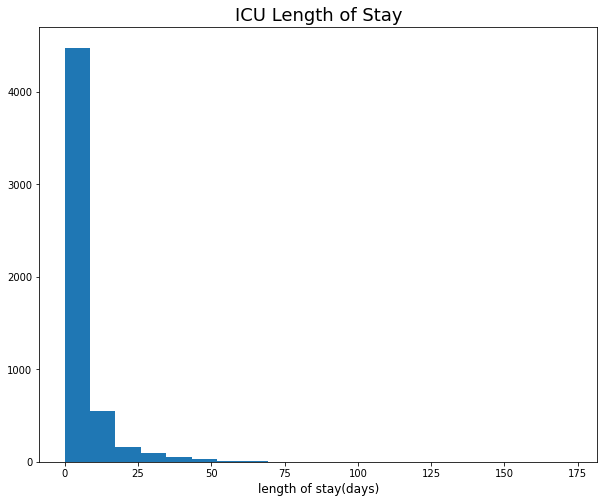

In [22]:
plt.figure(figsize=(10,8))
plt.hist(final_data['length_stay'], bins=20)
plt.title('ICU Length of Stay', fontdict = {'fontsize' : 18})
plt.xlabel('length of stay(days)', fontdict = {'fontsize' : 12})
plt.show()

## Data Preprocessing

In [23]:
# Import tableone
try:
    from tableone import TableOne, load_dataset
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne, load_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
#change unknowns to na
#marital status
ds_mod= final_data #change this line into what your dataset is
ds_mod['marital_status_descr'].loc[ds_mod['marital_status_descr'] == "UNKNOWN (DEFAULT)" ] = np.nan
ds_mod['marital_status_descr'].loc[ds_mod['marital_status_descr'] == "."] = np.nan
#ethnicity
ds_mod['ethnicity_descr'].loc[ds_mod['ethnicity_descr'].str.contains('ASIAN')] ='ASIAN'
ds_mod['ethnicity_descr'].loc[ds_mod['ethnicity_descr'].str.contains('BLACK')] ='BLACK'
ds_mod['ethnicity_descr'].loc[ds_mod['ethnicity_descr'].str.contains('WHITE')] ='WHITE'
ds_mod['ethnicity_descr'].loc[ds_mod['ethnicity_descr'].str.contains('HISPANIC')] ='HISPANIC'
ds_mod['ethnicity_descr'].loc[(ds_mod['ethnicity_descr'] == "UNKNOWN/NOT SPECIFIED") | (ds_mod['ethnicity_descr'] == "PATIENT DECLINED TO ANSWER") | (ds_mod['ethnicity_descr'] == "OTHER") | (ds_mod['ethnicity_descr'] == "UNABLE TO OBTAIN") ] = np.nan

#Religion
ds_mod['religion_descr'].loc[(ds_mod['religion_descr'] == "NOT SPECIFIED") | (ds_mod['religion_descr'] == ".") | (ds_mod['religion_descr'] == "OTHER") | (ds_mod['religion_descr'] == "UNOBTAINABLE") ] = np.nan
#admission source
ds_mod['admission_source_descr'].loc[ds_mod['admission_source_descr'].str.contains('TRANSFER') ] = 'TRANSFER'
ds_mod['admission_source_descr'].loc[ds_mod['admission_source_descr'].str.contains('REFERRAL') ] = 'REFERRAL'
ds_mod['admission_source_descr'].loc[ds_mod['admission_source_descr'] == "** INFO NOT AVAILABLE **" ] = np.nan
#sapsi
ds_mod['sapsi_max'].loc[ds_mod['sapsi_max']=='.' ] = np.nan
#sofa
ds_mod['sofa_max'].loc[ds_mod['sofa_max']=='.' ] = np.nan
#weight
ds_mod['weight_min'].loc[ds_mod['weight_min']=='.'] = np.nan

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
ds_mod.head()

,hadm_id,subject_id,marital_status_descr,ethnicity_descr,religion_descr,admission_type_descr,admission_source_descr,itemid,description,icustay_id,length_stay,los_group,gender,weight_min,sapsi_max,sofa_max,icustay_admit_age,icustay_first_careunit
0,2,24807,SINGLE,WHITE,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,60128,RESPIRATORY INFECTIONS & INFLAMMATIONS A,30800,1.0396,0-6 days,F,75.1,NaN,2.0,40.63657,MICU
1,3,7675,MARRIED,WHITE,JEWISH,EMERGENCY,TRANSFER,60460,NUTRITIONAL & MISC METABOLIC DISORDERS A,9564,4.8375,0-6 days,M,54.6,8.0,5.0,73.22510,MICU
2,6,23547,WIDOWED,WHITE,NaN,EMERGENCY,REFERRAL,60490,RENAL FAILURE,29253,10.1562,7-13 days,M,66.0,23.0,13.0,83.40483,MICU
3,10,14884,SEPARATED,NaN,PROTESTANT QUAKER,ELECTIVE,REFERRAL,60234,MAJOR SMALL & LARGE BOWEL PROCEDURES WIT,18494,1.3708,0-6 days,F,64.4,12.0,3.0,65.03839,CCU
4,12,8652,MARRIED,WHITE,EPISCOPALIAN,EMERGENCY,TRANSFER,60180,CORONARY BYPASS W/O PTCA OR CARDIAC CATH,10764,5.7632,0-6 days,M,97.7,21.0,11.0,84.23038,CSRU


In [26]:
ds_mod=ds_mod.dropna()
len(ds_mod)
#cleaned_df is the without NaN

2233

## Correlation Check

In [27]:
ds_mod = ds_mod.drop(['hadm_id', 'subject_id', 'itemid', 'icustay_id'], axis = 1)

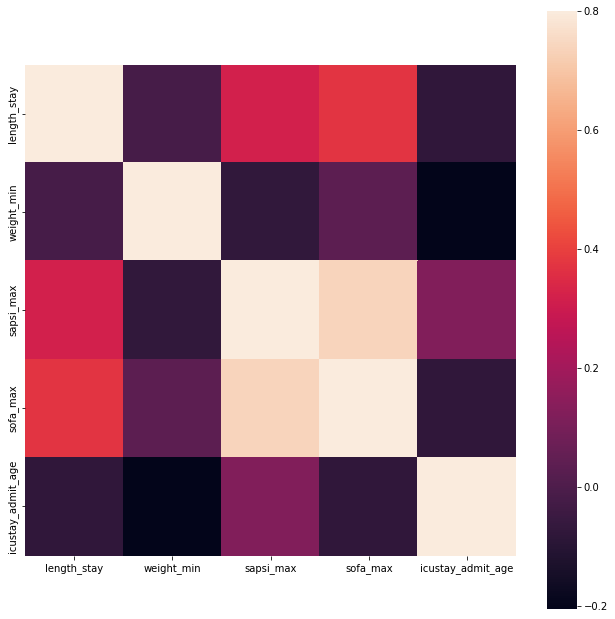

In [28]:
C_mat = ds_mod.corr()
fig = plt.figure(figsize = (11,11))

sns.heatmap(C_mat, vmax = .8, square = True)
#sns.set(font_scale=1.2)
plt.show()

According to the heatmap above, 'sapsi_max' and 'sofa_max' are highly correlated. We choose to drop 'sofa_max' for further regression models.

In [29]:
# Generate the final table after dropping 'sofa_max'
cleaned_df = ds_mod.drop('sofa_max', axis = 1)
cleaned_df.head()

,marital_status_descr,ethnicity_descr,religion_descr,admission_type_descr,admission_source_descr,description,length_stay,los_group,gender,weight_min,sapsi_max,icustay_admit_age,icustay_first_careunit
1,MARRIED,WHITE,JEWISH,EMERGENCY,TRANSFER,NUTRITIONAL & MISC METABOLIC DISORDERS A,4.8375,0-6 days,M,54.6,8.0,73.22510,MICU
4,MARRIED,WHITE,EPISCOPALIAN,EMERGENCY,TRANSFER,CORONARY BYPASS W/O PTCA OR CARDIAC CATH,5.7632,0-6 days,M,97.7,21.0,84.23038,CSRU
6,DIVORCED,WHITE,CATHOLIC,ELECTIVE,REFERRAL,"TRACHEOSTOMY FOR FACE, MOUTH & NECK DIAG",3.8188,0-6 days,M,97.5,19.0,54.17757,CSRU
7,MARRIED,WHITE,PROTESTANT QUAKER,EMERGENCY,EMERGENCY ROOM ADMIT,NUTRITIONAL & MISC METABOLIC DISORDERS A,4.0354,0-6 days,M,92.7,13.0,77.63651,MICU
8,MARRIED,WHITE,JEWISH,EMERGENCY,EMERGENCY ROOM ADMIT,"TRACHEOSTOMY EXCEPT FOR FACE, MOUTH & NE",35.2479,21+ days,M,76.9,20.0,67.34201,CSRU


In [30]:
columns = ['marital_status_descr', 'ethnicity_descr', 'religion_descr', 'admission_type_descr',
           'admission_source_descr', 'icustay_first_careunit', 'length_stay', 'los_group', 'gender', 'weight_min', 'sapsi_max', 
           'icustay_admit_age']
categorical = ['marital_status_descr', 'ethnicity_descr', 'religion_descr', 'admission_type_descr',
               'admission_source_descr', 'los_group', 'gender', 'icustay_first_careunit']
nonnormal = ['weight_min', 'sapsi_max', 'icustay_admit_age']
labels = {'marital_status_descr': 'Marital Status',
          'ethnicity_descr': 'Ethnicity',
          'religion_descr': 'Religion',
          'admission_type_descr': 'Admission Type',
          'admission_source_descr': 'Admission Source',
          'icustay_first_careunit' : 'ICU Care Unit',
          'los_group': 'Length of Stay Group',
          'gender': 'Gender',
          'weight_min': 'Weight',
          'sapsi_max' : 'SAPSI',
          'icustay_admit_age' : 'Age',
          'length_stay': 'Length of Stay'
          }
table1 = TableOne(cleaned_df, columns=columns, categorical=categorical, nonnormal=nonnormal, labels=labels)
print(table1)

/usr/local/lib/python3.8/dist-packages/tableone/tableone.py:225: DeprecationWarning: The labels argument is deprecated; use rename instead.
  warnings.warn("The labels argument is deprecated; use "


                                                                    Missing           Overall
n                                                                                        2233
Marital Status, n (%)       DIVORCED                                      0         128 (5.7)
                            MARRIED                                               1120 (50.2)
                            SEPARATED                                                30 (1.3)
                            SINGLE                                                 414 (18.5)
                            WIDOWED                                                541 (24.2)
Ethnicity, n (%)            AMERICAN INDIAN/ALASKA NATIVE                 0           1 (0.0)
                            ASIAN                                                    19 (0.9)
                            BLACK                                                  227 (10.2)
                            HISPANIC                        

In [31]:
table1.to_csv('table1.csv')

In [32]:
#cleaned_df.to_csv('./cleaned_df.csv', sep=',', index=False)

## LINEAR REGRESSION

In [33]:
xs = cleaned_df.drop(["description", "length_stay", 'los_group', ], axis=1)
X = pd.get_dummies(xs)
Y = cleaned_df['length_stay']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [34]:
X_train.head()

,weight_min,sapsi_max,icustay_admit_age,marital_status_descr_DIVORCED,marital_status_descr_MARRIED,marital_status_descr_SEPARATED,marital_status_descr_SINGLE,marital_status_descr_WIDOWED,ethnicity_descr_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_descr_ASIAN,...,admission_source_descr_EMERGENCY ROOM ADMIT,admission_source_descr_REFERRAL,admission_source_descr_TRANSFER,gender_F,gender_M,icustay_first_careunit_CCU,icustay_first_careunit_CSRU,icustay_first_careunit_FICU,icustay_first_careunit_MICU,icustay_first_careunit_SICU
4154,80.9,17.0,94.14671,0,0,0,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
4537,70.0,23.0,63.35137,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2245,83.0,27.0,66.06272,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
2664,84.2,10.0,72.93642,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
3391,77.0,3.0,49.46901,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [35]:
X_train.columns

Index(['weight_min', 'sapsi_max', 'icustay_admit_age',
       'marital_status_descr_DIVORCED', 'marital_status_descr_MARRIED',
       'marital_status_descr_SEPARATED', 'marital_status_descr_SINGLE',
       'marital_status_descr_WIDOWED',
       'ethnicity_descr_AMERICAN INDIAN/ALASKA NATIVE',
       'ethnicity_descr_ASIAN', 'ethnicity_descr_BLACK',
       'ethnicity_descr_HISPANIC', 'ethnicity_descr_MULTI RACE ETHNICITY',
       'ethnicity_descr_NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND',
       'ethnicity_descr_WHITE', 'religion_descr_7TH DAY ADVENTIST',
       'religion_descr_BAPTIST', 'religion_descr_BUDDHIST',
       'religion_descr_CATHOLIC', 'religion_descr_CHRISTIAN SCIENTIST',
       'religion_descr_EPISCOPALIAN', 'religion_descr_GREEK ORTHODOX',
       'religion_descr_HEBREW', 'religion_descr_HINDU',
       'religion_descr_JEHOVAH'S WITNESS', 'religion_descr_JEWISH',
       'religion_descr_LUTHERAN', 'religion_descr_METHODIST',
       'religion_descr_MUSLIM', 'religion_descr_PRO

In [36]:
mlr1 = linear_model.LinearRegression()
mlr1.fit(X_train, y_train)

LinearRegression()

In [37]:
y_predict = mlr1.predict(X_test)
print(mean_squared_error(y_test, y_predict))
#print(r2_score(y_test, y_predict))

53.32298677910298


In [38]:
print(mlr1.coef_)

[-1.21382525e-02  5.35093826e-01 -8.19312384e-02  2.95243521e+00
 -3.81773694e-01 -2.42785376e+00  1.66125748e-01 -3.08933503e-01
  2.08721929e-14  6.52169310e-01 -3.17996940e-01 -1.50233913e+00
  2.52101216e+00 -1.93448288e+00  5.81637485e-01  1.32603598e+01
 -4.22891043e+00 -4.31870190e+00 -2.80466603e+00  8.97962109e-01
  4.36996609e+00  1.89838907e+00  4.87188162e+00 -5.11241461e+00
 -3.80148613e+00 -3.01392941e+00 -4.09890926e+00  4.10886872e+00
  8.49623702e+00 -3.16486233e+00  1.57516635e+00 -8.93495069e+00
  1.41741560e+00 -1.36157980e+00 -5.58358032e-02 -2.33908203e-01
 -9.70287890e-01  1.20419609e+00 -1.03114744e-01  1.03114744e-01
  6.62738744e-01  2.19445536e-01  7.00982743e-01  1.19302370e-01
 -1.70246939e+00]


In [39]:
alphas = np.linspace(0.01,1,10000)
en = ElasticNet() 
coefs = []
mse = []

for a in alphas:
    en.set_params(alpha=a)
    en.fit(X_train, y_train)
    coefs.append(en.coef_)
    y_predict = en.predict(X_test)
    mse.append(mean_squared_error(y_test, y_predict))

Text(0.5, 1.0, 'ElasticNet coefficients vs. regularization lambda')

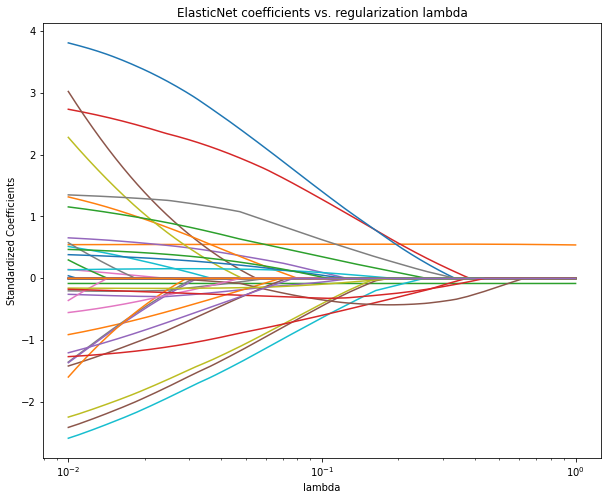

In [40]:
plt.figure(figsize=(10,8))    
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('Standardized Coefficients')
plt.title('ElasticNet coefficients vs. regularization lambda')

Text(0.5, 1.0, 'MSE vs. regularization lambda')

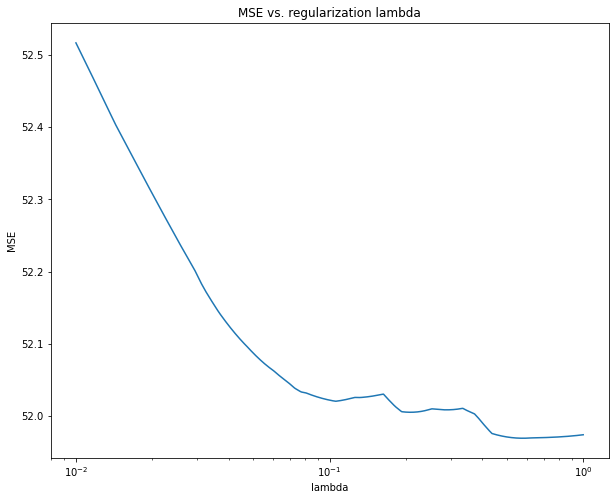

In [41]:
plt.figure(figsize=(10,8))    
ax = plt.gca()
ax.plot(alphas, mse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('MSE vs. regularization lambda')

In [42]:
l1_ratio = np.linspace(0.01,1,10000)
en = ElasticNet() 
coefs = []
mse = []

for a in l1_ratio:
    en.set_params(l1_ratio=a)
    en.fit(X_train, y_train)
    coefs.append(en.coef_)
    y_predict = en.predict(X_test)
    mse.append(mean_squared_error(y_test, y_predict))

Text(0.5, 1.0, 'ElasticNet coefficients vs. L1 and L2 penalties ratio')

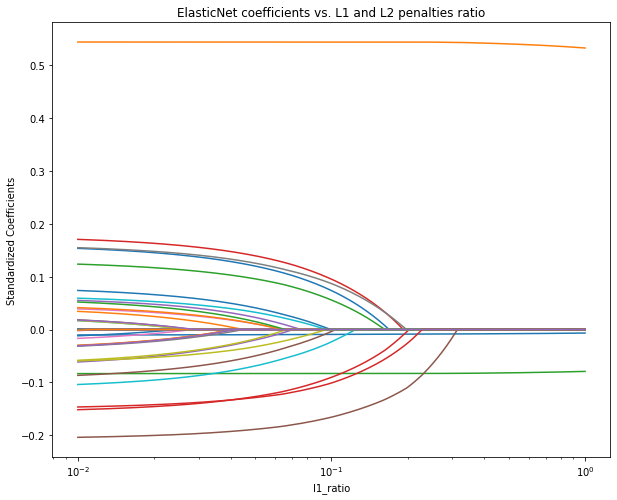

In [43]:
plt.figure(figsize=(10,8))    
ax = plt.gca()
ax.plot(l1_ratio, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('l1_ratio')
plt.ylabel('Standardized Coefficients')
plt.title('ElasticNet coefficients vs. L1 and L2 penalties ratio')

Text(0.5, 1.0, 'MSE vs. L1 and L2 penalties ratio')

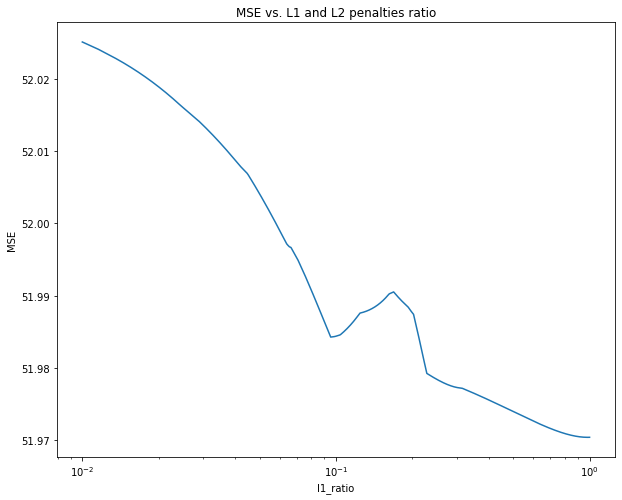

In [44]:
plt.figure(figsize=(10,8))    
ax = plt.gca()
ax.plot(l1_ratio, mse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('l1_ratio')
plt.ylabel('MSE')
plt.title('MSE vs. L1 and L2 penalties ratio')

In [45]:
# use cross validation to choose the optimal Lasso Regression model for this data set
bestReg = ElasticNetCV(cv = 5).fit(X_train, y_train)
print(bestReg.alpha_)
print(bestReg.l1_ratio_)
print(bestReg.coef_)

0.4255538803450411
0.5
[-0.00875038  0.55251875 -0.08333721  0.         -0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.          0.          0.          0.         -0.         -0.
 -0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.          0.          0.         -0.
  0.         -0.          0.         -0.          0.         -0.22448856
  0.          0.         -0.          0.          0.          0.
  0.         -0.0098205  -0.        ]


In [46]:
y_predict = bestReg.predict(X_test)
print(mean_squared_error(y_test, y_predict))

51.979829472258345


## Regression Tree

In [47]:
MSE_train = []
MSE_test = []

for i in range(1,500):
    #Paramterize the model and let i be the number of minimum instances per leaf node
    regression_model = tree.DecisionTreeRegressor(criterion="squared_error",min_samples_leaf=i)   
    #Train the model
    regression_model.fit(X_train, y_train)
    #Predict query instances
    predicted_train = regression_model.predict(X_train)
    predicted_test = regression_model.predict(X_test)
    #Calculate and append the RMSEs
    MSE_train.append(np.sum(((y_train-predicted_train)**2)/len(y_train)))
    MSE_test.append(np.sum(((y_test-predicted_test)**2)/len(y_test)))


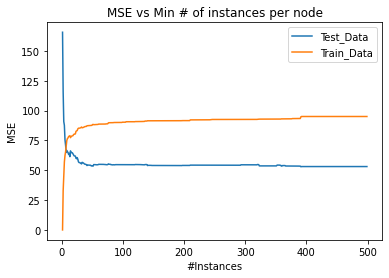

In [48]:
fig = plt.figure()
ax0 = fig.add_subplot(111) 
ax0.plot(range(1,500), MSE_test, label='Test_Data')
ax0.plot(range(1,500), MSE_train, label='Train_Data')
ax0.legend()
ax0.set_title('MSE vs Min # of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('MSE')
plt.show()


In [49]:
min_leaf = np.argmin(MSE_test)
print(min_leaf)

390


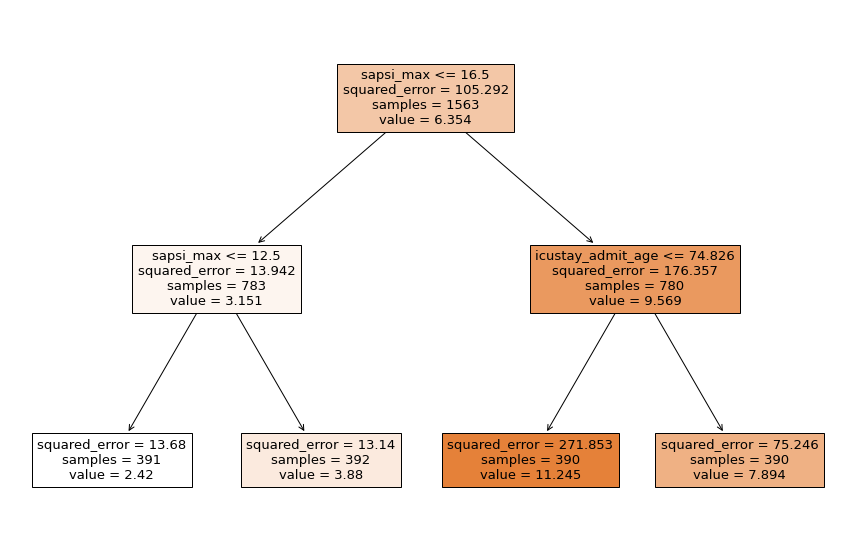

In [50]:
regr = tree.DecisionTreeRegressor(min_samples_leaf = 390).fit(X_train, y_train)
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(regr, filled=True, feature_names = X.columns)

In [51]:
predicted_test = regr.predict(X_test)
MSE_test = np.sum(((y_test-predicted_test)**2)/len(y_test))
print(MSE_test)

53.408779525001535


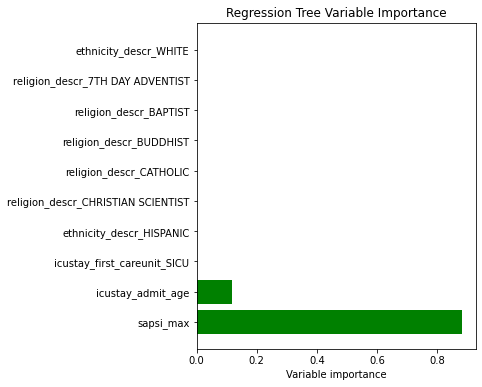

In [52]:
fig, ax = plt.subplots(figsize=(5,6))
inds = np.argsort(regr.feature_importances_)
inds = np.flip(inds)
ax.barh(np.arange(10), regr.feature_importances_[inds[:10]], color='green')
ax.set_yticks(np.arange(10))
_ = ax.set_yticklabels(X.columns[inds])
_ = ax.set_xlabel('Variable importance')
_ = ax.set_title('Regression Tree Variable Importance')

## Random forest regression 

Next, we'll build an ensemble of trees using random forests. We'll look at the "out of bag" (OOB) error as we increase the number of trees in the ensemble.


In [53]:
oob_error = []
num_trees = np.arange(10, 180, 20)
rf = ensemble.RandomForestRegressor(min_samples_leaf=100, max_features=4, 
                                    criterion='squared_error', oob_score=True)
for m in tqdm(num_trees):
    rf.set_params(n_estimators=m)
    model = rf.fit(X_train, y_train)
    oob_error.append(1-model.oob_score_)


  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


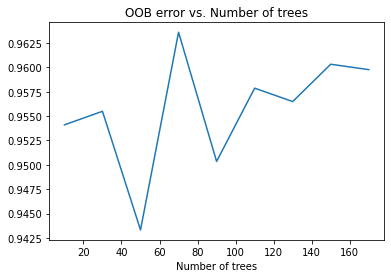

In [54]:
plt.plot(num_trees, oob_error)
plt.title('OOB error vs. Number of trees')
_ = plt.xlabel('Number of trees')

In [55]:
num_of_trees = num_trees[np.argmin(oob_error)]
print(num_of_trees)

50


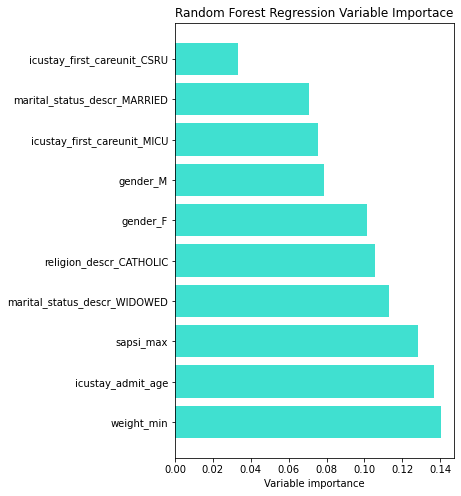

In [56]:
rf.set_params(n_estimators=90)
model = rf.fit(X_test, y_test)

fig, ax = plt.subplots(figsize=(5,8))
inds = np.argsort(model.feature_importances_)
inds = np.flip(inds)
ax.barh(np.arange(10), model.feature_importances_[inds[:10]], color='turquoise')
ax.set_yticks(np.arange(10))
_ = ax.set_yticklabels(X.columns[inds])
_ = ax.set_xlabel('Variable importance')
_ = ax.set_title('Random Forest Regression Variable Importace')

## Artificial Neural Network

In [57]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_absolute_error 
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

### model 1

In [58]:
xs = cleaned_df.drop(["length_stay",'los_group'], axis=1)
xs['sapsi_max'] = np.asarray(xs['sapsi_max']).astype(np.float32)
xs['weight_min'] = np.asarray(xs['weight_min']).astype(np.float32)
xs['icustay_admit_age'] = np.asarray(xs['icustay_admit_age']).astype(np.float32)
X = pd.get_dummies(xs, columns = ['marital_status_descr', 'ethnicity_descr', 'religion_descr',
       'admission_type_descr', 'admission_source_descr', 'description',
       'gender', 'icustay_first_careunit']) 
Y = cleaned_df['length_stay']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [59]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               38784     
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 203,649
Trainable params: 203,649
Non-trainable params: 0
_________________________________________________________________


In [60]:
batch_size = 128
epochs = 500

NN_model.compile(loss="mae", optimizer="adam", metrics=["mean_squared_error"])

NN_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/500
11/11 [==============================] - 1s 26ms/step - loss: 4.8592 - mean_squared_error: 123.6016 - val_loss: 4.3027 - val_mean_squared_error: 70.9672
Epoch 2/500
11/11 [==============================] - 0s 11ms/step - loss: 4.5706 - mean_squared_error: 118.3822 - val_loss: 4.3662 - val_mean_squared_error: 73.0400
Epoch 3/500
11/11 [==============================] - 0s 11ms/step - loss: 4.4585 - mean_squared_error: 116.0734 - val_loss: 4.0636 - val_mean_squared_error: 62.2397
Epoch 4/500
11/11 [==============================] - 0s 12ms/step - loss: 4.3519 - mean_squared_error: 110.6946 - val_loss: 3.9735 - val_mean_squared_error: 60.8336
Epoch 5/500
11/11 [==============================] - 0s 9ms/step - loss: 4.2731 - mean_squared_error: 106.6924 - val_loss: 4.0691 - val_mean_squared_error: 63.7891
Epoch 6/500
11/11 [==============================] - 0s 12ms/step - loss: 4.2612 - mean_squared_error: 105.7174 - val_loss: 4.0800 - val_mean_squared_error: 63.9087
Epoch 7/500

In [61]:
predictions = NN_model.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print(mse)

21/21 [==============================] - 0s 2ms/step
62.87559582051146


In [62]:
### model 2

In [63]:
#try another model: add dropout layers to avoid overfitting
NN_model2 = Sequential()

# The Input Layer :
NN_model2.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dropout(rate=0.2))
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model2.add(Dropout(rate=0.2))
NN_model2.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model2.add(Dense(1, kernel_initializer='normal',activation='linear'))


# Compile the network :
NN_model2.compile(loss='mae', optimizer='adam', metrics=['mse'])
NN_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               38784     
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 1)                

In [64]:
batch_size = 128
epochs = 1000

NN_model2.compile(loss="mae", optimizer="adam", metrics=["mean_squared_error"])

NN_model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/1000
11/11 [==============================] - 1s 28ms/step - loss: 4.8257 - mean_squared_error: 123.8615 - val_loss: 4.4354 - val_mean_squared_error: 74.3709
Epoch 2/1000
11/11 [==============================] - 0s 15ms/step - loss: 4.6340 - mean_squared_error: 120.4148 - val_loss: 4.2268 - val_mean_squared_error: 69.4855
Epoch 3/1000
11/11 [==============================] - 0s 16ms/step - loss: 4.5346 - mean_squared_error: 117.4638 - val_loss: 4.1157 - val_mean_squared_error: 64.0038
Epoch 4/1000
11/11 [==============================] - 0s 17ms/step - loss: 4.4752 - mean_squared_error: 113.6203 - val_loss: 4.1065 - val_mean_squared_error: 59.2466
Epoch 5/1000
11/11 [==============================] - 0s 14ms/step - loss: 4.4326 - mean_squared_error: 111.6225 - val_loss: 3.9846 - val_mean_squared_error: 60.9174
Epoch 6/1000
11/11 [==============================] - 0s 11ms/step - loss: 4.3150 - mean_squared_error: 109.0749 - val_loss: 3.9717 - val_mean_squared_error: 61.0694
Epoc

In [65]:
predictions = NN_model2.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print(mse)

21/21 [==============================] - 0s 2ms/step
60.026937311283774


This is the best regression model we have identified in the ANN model. The lowest test MSE we identified is 53, but given the randomness of the model, it varies each time you retrain the model.

### model 3

In [66]:
#try another model: larger batch size
NN_model3 = Sequential()

# The Input Layer :
NN_model3.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model3.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model3.add(Dropout(rate=0.2))
NN_model3.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model3.add(Dense(1, kernel_initializer='normal',activation='linear'))


# Compile the network :
batch_size = 128
epochs = 500

NN_model3.compile(loss="mae", optimizer="adam", metrics=["mean_squared_error"])
NN_model3.summary()
NN_model3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               38784     
                                                                 
 dense_11 (Dense)            (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               65792     
                                                                 
 dense_13 (Dense)            (None, 1)                 257       
                                                                 
Total params: 137,857
Trainable params: 137,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
11/11 [=============================

In [67]:
predictions = NN_model3.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print(mse)

21/21 [==============================] - 0s 1ms/step
71.68873058286327


### model 4

In [68]:
#try another model: larger batch size
NN_model4 = Sequential()

# The Input Layer :
NN_model4.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model4.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model4.add(Dropout(rate=0.2))
NN_model4.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model4.add(Dense(1, kernel_initializer='normal',activation='linear'))
NN_model4.summary()

# Compile the network :
batch_size = 256
epochs = 500

#NN_model4.compile(loss="mae", optimizer="adam", metrics=["mean_squared_error"])
#NN_model4.summary()
#NN_model4.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               38784     
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 137,857
Trainable params: 137,857
Non-trainable params: 0
_________________________________________________________________


In [69]:
predictions = NN_model4.predict(X_test)
mse = mean_squared_error(predictions, y_test)
print(mse)

21/21 [==============================] - 0s 2ms/step
94.98951551577946


### model 5

In [70]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)  
Y = cleaned_df['los_group']
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
Y = np.array(label_encoder.fit_transform(Y))
Y_transform = np.zeros((Y.shape[0], np.max(Y)+1))
for i in range(Y.shape[0]):
  Y_transform[i][Y[i]] = 1
X_train, X_test, y_train, y_test = train_test_split(X, Y_transform, test_size=0.3, random_state=42)

In [71]:
import keras
import tensorflow as tf
NN5_model = Sequential()

# The Input Layer :
NN5_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN5_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN5_model.add(Dropout(rate=0.2))

# The Output Layer :
NN5_model.add(Dense(4, kernel_initializer='normal',activation='softmax'))

batch_size = 128
epochs = 500

NN5_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2,beta_1=0.6),
                  metrics=['categorical_accuracy'])

NN5_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)



Epoch 1/500
10/10 [==============================] - 1s 35ms/step - loss: 8.5675 - categorical_accuracy: 0.6336 - val_loss: 3.6129 - val_categorical_accuracy: 0.7604
Epoch 2/500
10/10 [==============================] - 0s 13ms/step - loss: 2.8809 - categorical_accuracy: 0.7640 - val_loss: 2.3752 - val_categorical_accuracy: 0.7604
Epoch 3/500
10/10 [==============================] - 0s 13ms/step - loss: 2.0767 - categorical_accuracy: 0.7640 - val_loss: 1.8529 - val_categorical_accuracy: 0.7604
Epoch 4/500
10/10 [==============================] - 0s 12ms/step - loss: 1.7682 - categorical_accuracy: 0.7640 - val_loss: 1.6190 - val_categorical_accuracy: 0.7604
Epoch 5/500
10/10 [==============================] - 0s 11ms/step - loss: 1.6056 - categorical_accuracy: 0.7640 - val_loss: 1.5554 - val_categorical_accuracy: 0.7604
Epoch 6/500
10/10 [==============================] - 0s 13ms/step - loss: 1.5349 - categorical_accuracy: 0.7640 - val_loss: 1.5285 - val_categorical_accuracy: 0.7604
Epoc

In [72]:
predictions = NN_model.predict(X_test)
_, train_acc = NN_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = NN_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

21/21 [==============================] - 0s 2ms/step
Train: 141.899, Test: 89.012


### model 6

In [73]:
import keras
import tensorflow as tf
NN6_model = Sequential()

# The Input Layer :
NN6_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN6_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN6_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN6_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))

# The Output Layer :
NN6_model.add(Dense(4, kernel_initializer='normal',activation='softmax'))

batch_size = 128
epochs = 200

NN6_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2,beta_1=0.6),
                  metrics=['categorical_accuracy'])

NN6_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/200
10/10 [==============================] - 1s 29ms/step - loss: 32.0327 - categorical_accuracy: 0.6592 - val_loss: 9.4037 - val_categorical_accuracy: 0.7604
Epoch 2/200
10/10 [==============================] - 0s 12ms/step - loss: 6.7931 - categorical_accuracy: 0.7640 - val_loss: 5.1239 - val_categorical_accuracy: 0.7604
Epoch 3/200
10/10 [==============================] - 0s 11ms/step - loss: 4.9177 - categorical_accuracy: 0.7640 - val_loss: 4.7687 - val_categorical_accuracy: 0.7604
Epoch 4/200
10/10 [==============================] - 0s 12ms/step - loss: 4.6770 - categorical_accuracy: 0.7640 - val_loss: 4.4117 - val_categorical_accuracy: 0.7604
Epoch 5/200
10/10 [==============================] - 0s 12ms/step - loss: 4.5893 - categorical_accuracy: 0.7640 - val_loss: 4.5325 - val_categorical_accuracy: 0.7604
Epoch 6/200
10/10 [==============================] - 0s 12ms/step - loss: 4.5737 - categorical_accuracy: 0.7640 - val_loss: 4.5676 - val_categorical_accuracy: 0.7604
Epo

In [74]:
_, train_acc = NN6_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = NN6_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.763, Test: 0.766


### model 7

In [75]:
import keras
import tensorflow as tf
NN7_model = Sequential()

# The Input Layer :
NN7_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN7_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN7_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN7_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))

# The Output Layer :
NN7_model.add(Dense(4, kernel_initializer='normal',activation='softmax'))

batch_size = 256
epochs = 200

NN7_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2,beta_1=0.6),
                  metrics=['categorical_accuracy'])

NN7_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/200
5/5 [==============================] - 1s 59ms/step - loss: 48.0100 - categorical_accuracy: 0.4872 - val_loss: 24.9761 - val_categorical_accuracy: 0.7604
Epoch 2/200
5/5 [==============================] - 0s 21ms/step - loss: 17.8890 - categorical_accuracy: 0.7640 - val_loss: 10.5591 - val_categorical_accuracy: 0.7604
Epoch 3/200
5/5 [==============================] - 0s 16ms/step - loss: 8.7453 - categorical_accuracy: 0.7640 - val_loss: 6.8609 - val_categorical_accuracy: 0.7604
Epoch 4/200
5/5 [==============================] - 0s 19ms/step - loss: 6.1708 - categorical_accuracy: 0.7640 - val_loss: 5.3570 - val_categorical_accuracy: 0.7604
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 5.1822 - categorical_accuracy: 0.7640 - val_loss: 4.8990 - val_categorical_accuracy: 0.7604
Epoch 6/200
5/5 [==============================] - 0s 21ms/step - loss: 4.8219 - categorical_accuracy: 0.7640 - val_loss: 4.7449 - val_categorical_accuracy: 0.7604
Epoch 7/200


In [76]:
_, train_acc = NN7_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = NN7_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.763, Test: 0.766


### model 8

In [77]:
import keras
import tensorflow as tf
NN8_model = Sequential()

# The Input Layer :
NN8_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN8_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN8_model.add(Dropout(rate=0.2))
NN8_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN8_model.add(Dropout(rate=0.2))
NN8_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN8_model.add(Dropout(rate=0.2))
NN8_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN8_model.add(Dropout(rate=0.2))
NN8_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN8_model.add(Dropout(rate=0.2))
NN8_model.add(Dense(256, kernel_initializer='normal',activation='relu',kernel_regularizer=tf.keras.regularizers.L1(0.01),))
NN8_model.add(Dropout(rate=0.2))

# The Output Layer :
NN8_model.add(Dense(4, kernel_initializer='normal',activation='softmax'))

batch_size = 128
epochs = 200

NN8_model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2,beta_1=0.6),
                  metrics=['categorical_accuracy'])

NN8_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/200
10/10 [==============================] - 2s 44ms/step - loss: 61.6233 - categorical_accuracy: 0.7032 - val_loss: 14.1485 - val_categorical_accuracy: 0.7604
Epoch 2/200
10/10 [==============================] - 0s 19ms/step - loss: 10.9069 - categorical_accuracy: 0.7640 - val_loss: 9.2239 - val_categorical_accuracy: 0.7604
Epoch 3/200
10/10 [==============================] - 0s 20ms/step - loss: 9.3464 - categorical_accuracy: 0.7640 - val_loss: 9.5461 - val_categorical_accuracy: 0.7604
Epoch 4/200
10/10 [==============================] - 0s 19ms/step - loss: 9.4076 - categorical_accuracy: 0.7640 - val_loss: 8.8164 - val_categorical_accuracy: 0.7604
Epoch 5/200
10/10 [==============================] - 0s 19ms/step - loss: 9.3499 - categorical_accuracy: 0.7640 - val_loss: 9.2500 - val_categorical_accuracy: 0.7604
Epoch 6/200
10/10 [==============================] - 0s 20ms/step - loss: 9.3647 - categorical_accuracy: 0.7640 - val_loss: 9.4040 - val_categorical_accuracy: 0.7604
E

In [78]:
_, train_acc = NN8_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = NN8_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

type(X_test)
y_pred = NN8_model.predict(X_test[:1])

NN8_model.summary()


Train: 0.763, Test: 0.766
1/1 [==============================] - 0s 102ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 128)               38784     
                                                                 
 dense_32 (Dense)            (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                         

In [79]:
print(X_test[:1])
print(y_test[:1])
print(y_pred)

      weight_min  sapsi_max  icustay_admit_age  marital_status_descr_DIVORCED  \
2456   85.199997        9.0           79.05616                              0   

      marital_status_descr_MARRIED  marital_status_descr_SEPARATED  \
2456                             0                               0   

      marital_status_descr_SINGLE  marital_status_descr_WIDOWED  \
2456                            0                             1   

      ethnicity_descr_AMERICAN INDIAN/ALASKA NATIVE  ethnicity_descr_ASIAN  \
2456                                              0                      0   

      ...  description_VIRAL ILLNESS AGE >17                     \
2456  ...                                                  0      

      description_WND DEBRID & SKN GRFT EXCEPT HAND,FOR MU  \
2456                                                  0      

      description_WOUND DEBRIDEMENTS FOR INJURIES           gender_F  \
2456                                                  0            0   


This NN8_model is the best model we have identified out of all the classification model. Above is basic information of patient 1 in the test dataset along with probability matrix produced from the model, by inputing first patient's information into the model.

### model 9

In [80]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dropout(rate=0.2))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))


# The Output Layer :
NN_model.add(Dense(4, kernel_initializer='normal',activation='linear'))


In [81]:
batch_size = 128
epochs = 500

NN_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = NN_model.fit(X_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       validation_data=(X_test, y_test))

Epoch 1/500
13/13 [==============================] - 1s 29ms/step - loss: 1.8895 - accuracy: 0.7006 - val_loss: 0.7475 - val_accuracy: 0.7657
Epoch 2/500
13/13 [==============================] - 0s 11ms/step - loss: 8.3414 - accuracy: 0.7633 - val_loss: 15.5407 - val_accuracy: 0.7657
Epoch 3/500
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.7588 - val_loss: 15.5407 - val_accuracy: 0.7657
Epoch 4/500
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.5470 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 5/500
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2924 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 6/500
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2194 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 7/500
13/13 [==============================] - 0s 10ms/step - loss: 15.3653 - accuracy: 0.2201 - val_loss: 15.5407 - val_accuracy: 0.

In [82]:
_, train_acc = NN_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = NN_model.evaluate(X_test, y_test, verbose=0)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.129, Test: 0.151


In [83]:
batch_size = 128
epochs = 50

NN_model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

history = NN_model.fit(X_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 1s 21ms/step - loss: 15.3653 - accuracy: 0.2156 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 2/50
13/13 [==============================] - 0s 10ms/step - loss: 15.3653 - accuracy: 0.2079 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 3/50
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2009 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2099 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 5/50
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2169 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2067 - val_loss: 15.5407 - val_accuracy: 0.1507
Epoch 7/50
13/13 [==============================] - 0s 11ms/step - loss: 15.3653 - accuracy: 0.2118 - val_loss: 15.5407 - val_accuracy: 0.1507

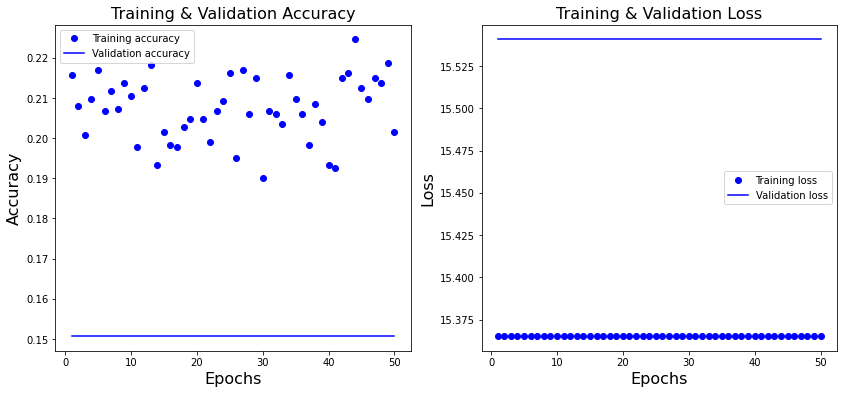

In [84]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

The learning curve shows the ANN model converges during the first few epochs.